In [108]:
import numpy as np
import pandas as pd
import geopandas as gpd
import fiona
import glob
import os
import contextily as ctx
from scipy.spatial import cKDTree
from shapely.geometry import Point
import json
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map, thread_map
pd.set_option('min_rows', 30)
import sys
sys.path.append('..')
from importlib import reload
# import src.utils as utils
# reload(utils)
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 12)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
max_workers = 30

In [27]:
def gdf2tree(gdf):
    return cKDTree(np.array(list(gdf[~gdf.geometry.isna()].geometry.apply(lambda x: (x.x, x.y)))))

In [3]:
%%time
## read in
df = pd.read_csv("restricted/BCs_issued_by_AUP_TLADCs_2021FEB (1).csv", encoding='cp1252')
bcs = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X_Coordinate, df.Y_Coordinate))

CPU times: user 1.71 s, sys: 147 ms, total: 1.85 s
Wall time: 1.85 s


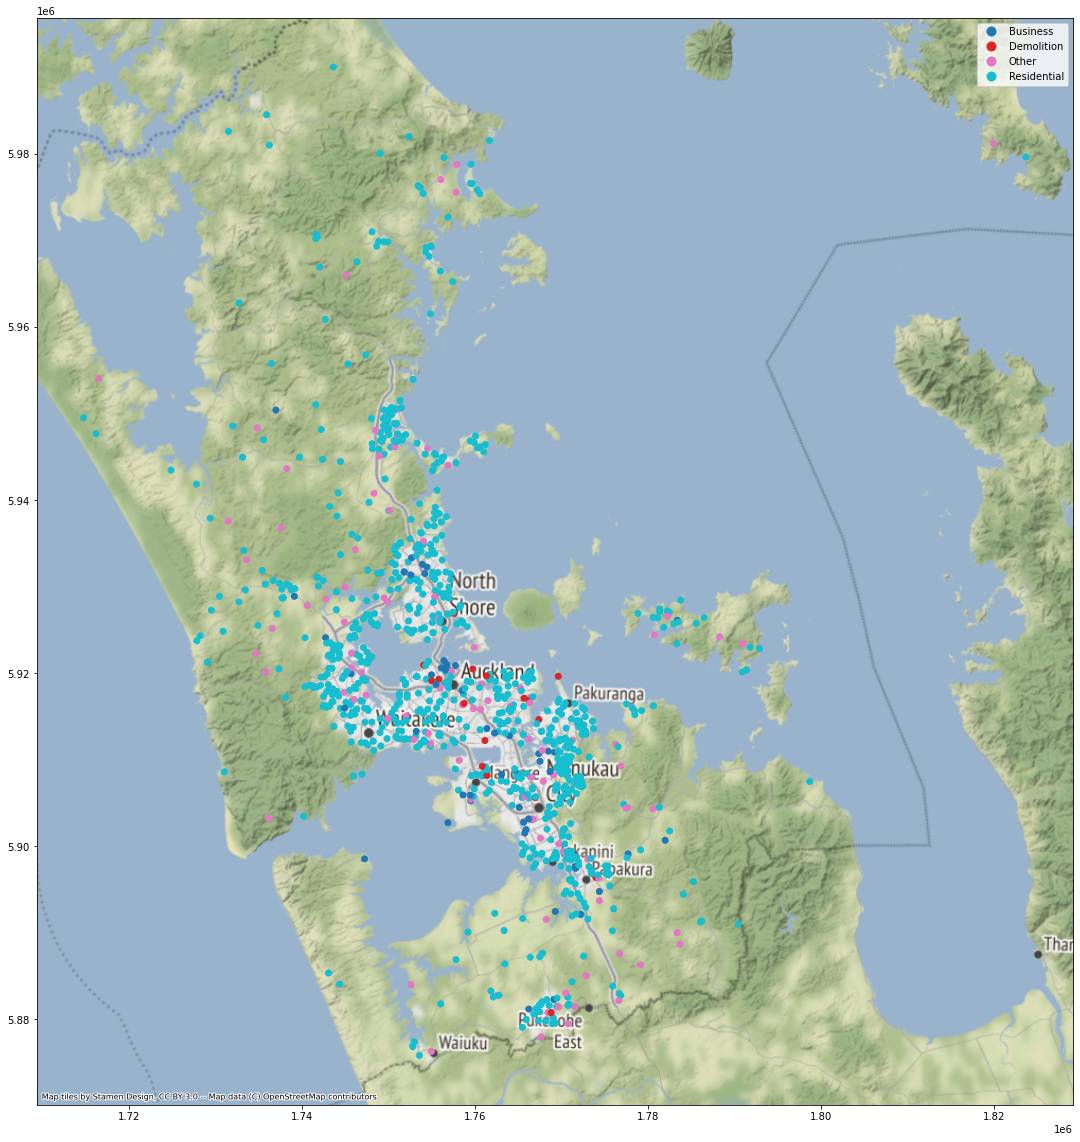

In [8]:
ax = bcs.sample(1000).plot(column='Building_Type_Group', legend=True, figsize=(20,20))
ctx.add_basemap(ax, crs=bcs.crs)

In [12]:
# addressing of building consents is very inconsistent
# some building consents have street name in ADDRESS_2, some have suburb, some even have 'Auckland'
bcs[bcs.ADDRESS_2 == 'Auckland'].sample(5)

,OBS,CONSENT_DATE,MARCH_YEAR,ADDRESS_1,ADDRESS_2,ADDRESS_3,LB_Name,BUILDING_TYPE_NAME,BUILDING_TYPE_CODE,FLOOR_AREA,VALUE,BUILDINGS,Building_Type_Group,Residential_Type,Business_Group,Business_Category,Type_Class_Year,MBCODE,MBYEAR,AUP_BaseZone,AUP_BaseZone_Group,ZONE,ZONE_ID,ZONE_NAME,ZONE_TYPE,BUSINESS_TYPE,PlanAreaName,SHA_Name_154,X_Coordinate,Y_Coordinate,geometry,number_name,full_address
24606,188219,"Nov 01, 2018 12:00:00 AM","Mar 01, 2019 12:00:00 AM",528 DON BUCK ROAD,Auckland,NaN,Henderson - Massey,"Townhouses, flats, units, and other dwellings",1129,104.0,188640.0,1,Residential,Attached,NaN,NaN,2014,226402.0,2013.0,Residential - Mixed Housing Urban Zone,Residential,60.0,WCC_6,Foothills,Rural,NaN,Redhills (Fred Taylor Drive) – Stage 1,Redhills (Fred Taylor Drive) – Stage 1,174.603215,-36.824411,POINT (1742980.373 5923406.830),528 don,528 don buck road auckland
24614,188227,"Nov 01, 2018 12:00:00 AM","Mar 01, 2019 12:00:00 AM",524-526 Don Buck Road,Auckland,NaN,Henderson - Massey,"Townhouses, flats, units, and other dwellings",1129,135.0,216000.0,1,Residential,Attached,NaN,NaN,2014,226403.0,2013.0,Residential - Mixed Housing Urban Zone,Residential,60.0,WCC_7,Living,Residential,NaN,Redhills (Fred Taylor Drive) – Stage 1,Redhills (Fred Taylor Drive) – Stage 1,174.607308,-36.824848,POINT (1743344.658 5923352.259),524-526 don,524-526 don buck road auckland
24604,188217,"Nov 01, 2018 12:00:00 AM","Mar 01, 2019 12:00:00 AM",528 DON BUCK ROAD,Auckland,NaN,Henderson - Massey,"Townhouses, flats, units, and other dwellings",1129,136.0,245889.0,1,Residential,Attached,NaN,NaN,2014,226402.0,2013.0,Residential - Mixed Housing Urban Zone,Residential,60.0,WCC_6,Foothills,Rural,NaN,Redhills (Fred Taylor Drive) – Stage 1,Redhills (Fred Taylor Drive) – Stage 1,174.603215,-36.824411,POINT (1742980.373 5923406.830),528 don,528 don buck road auckland
24618,188231,"Nov 01, 2018 12:00:00 AM","Mar 01, 2019 12:00:00 AM",528 DON BUCK ROAD,Auckland,NaN,Henderson - Massey,"Townhouses, flats, units, and other dwellings",1129,136.0,245622.0,1,Residential,Attached,NaN,NaN,2014,226402.0,2013.0,Residential - Mixed Housing Urban Zone,Residential,60.0,WCC_6,Foothills,Rural,NaN,Redhills (Fred Taylor Drive) – Stage 1,Redhills (Fred Taylor Drive) – Stage 1,174.603215,-36.824411,POINT (1742980.373 5923406.830),528 don,528 don buck road auckland
24619,188232,"Nov 01, 2018 12:00:00 AM","Mar 01, 2019 12:00:00 AM",528 DON BUCK ROAD,Auckland,NaN,Henderson - Massey,"Townhouses, flats, units, and other dwellings",1129,181.0,327384.0,1,Residential,Attached,NaN,NaN,2014,226402.0,2013.0,Residential - Mixed Housing Urban Zone,Residential,60.0,WCC_6,Foothills,Rural,NaN,Redhills (Fred Taylor Drive) – Stage 1,Redhills (Fred Taylor Drive) – Stage 1,174.603215,-36.824411,POINT (1742980.373 5923406.830),528 don,528 don buck road auckland


In [5]:
# one address has no ADDRESS_1, but an ADDRESS_2 with a leading digit
display(bcs[bcs.ADDRESS_1.isna() & ~bcs.ADDRESS_2.isna()][bcs[bcs.ADDRESS_1.isna() & ~bcs.ADDRESS_2.isna()].ADDRESS_2.str.contains('^[0-9]', regex=True)])
# move address 2 to address 1 for that one BC...
bcs.loc[bcs.OBS == 146813, 'ADDRESS_1'] = "25 HOLLYFORD DRV"
bcs.loc[bcs.OBS == 146813, 'ADDRESS_2'] = ""

,OBS,CONSENT_DATE,MARCH_YEAR,ADDRESS_1,ADDRESS_2,ADDRESS_3,LB_Name,BUILDING_TYPE_NAME,BUILDING_TYPE_CODE,FLOOR_AREA,VALUE,BUILDINGS,Building_Type_Group,Residential_Type,Business_Group,Business_Category,Type_Class_Year,MBCODE,MBYEAR,AUP_BaseZone,AUP_BaseZone_Group,ZONE,ZONE_ID,ZONE_NAME,ZONE_TYPE,BUSINESS_TYPE,PlanAreaName,SHA_Name_154,X_Coordinate,Y_Coordinate,geometry
64127,146813,"Sep 01, 2013 12:00:00 AM","Mar 01, 2013 12:00:00 AM",NaN,25 HOLLYFORD DRV,CLOVER PARK,Howick,"New (and pre-built) house, unit, bach, crib, b...",1100,239.0,240000.0,1,Residential,Detached,NaN,NaN,1998,716014.0,2013.0,Residential - Mixed Housing Suburban Zone,Residential,18.0,MCC_MR,Main Residential,Residential,NaN,NaN,NaN,174.896997,-36.986932,POINT (1768824.791 5904895.491)


In [6]:
%%time
# get number and name of street (but not 'road', 'street', 'place' etc)
# this can be used to match addresses with building consents

def number_name_bc(x):
    """extract street number and first complete word of the street name from building consents"""
    if x.ADDRESS_1 is None:
        pass
    else:
        # get number and first word of address
        joined_address = ' '.join([str(x[f'ADDRESS_{i}']) for i in [1,2, 3]]).lower()
        return ' '.join(joined_address.split(' ')[:2])

def full_address_bc(x):
    """extract full address from building consents"""
    if x.ADDRESS_1 is None:
        pass
    else:
        # get number and first word of address
        joined_address = ' '.join([str(x[f'ADDRESS_{i}']) for i in [1,2, 3] if not str(x[f'ADDRESS_{i}']) == 'nan']).lower()
        return joined_address

bcs['number_name'] = bcs.apply(number_name_bc, axis=1)
bcs['full_address'] = bcs.apply(full_address_bc, axis=1)

# there will still be some cases where there is no street number
display(bcs.number_name.sample(5))

185922       32 moss
181870         1 old
75708     61 pilling
164541        286 mt
151898     87 kervil
Name: number_name, dtype: object

CPU times: user 48.1 s, sys: 578 ms, total: 48.7 s
Wall time: 48.7 s


In [7]:
# check the number of rows where number_name has its last character as numeric; this should be zero
print(sum(bcs['number_name'].apply(lambda x: x[-1] in [i for i in range(10)])))

0


#### Split into three branches:  
- those with an address number range (e.g. 10-20)
- those with a single number (e.g. 10)
- those with no number  

Those with no number cannot be matched with addresses to get a more accuract coordinate.

In [9]:
bcs_non_na = bcs[~bcs.ADDRESS_1.isna()]
bcs_ranged = bcs_non_na[bcs_non_na.ADDRESS_1.str.contains('^[0-9]+-[0-9]', regex=True)]
# get all bcs which start with a digit
bcs_numbered = bcs_non_na[bcs_non_na.ADDRESS_1.str.contains('^[0-9]', regex=True)]
# exclude those in bcs_ranged
bcs_numbered = bcs_numbered[~bcs_numbered.ADDRESS_1.str.contains('^[0-9]+-[0-9]', regex=True)]
bcs_others = pd.concat([bcs_non_na[~bcs_non_na.ADDRESS_1.str.contains('^[0-9]', regex=True)], bcs[bcs.ADDRESS_1.isna()]])
print('non na bcs:', len(bcs_non_na))
print()
print('1. ranged:', len(bcs_ranged))
print('2. numbered:', len(bcs_numbered))
print('3. non ranged/non numbered:', len(bcs_others))
print('total bcs:', len(bcs))
print('sum of 1, 2, 3:', len(bcs_ranged) + len(bcs_numbered) + len(bcs_others))

non na: 193005
1. ranged: 6267
2. numbered: 183013
3. non ranged/non numbered: 17946
total bcs: 207226
sum of 1, 2, 3: 207226


## How many building consents have coordinates that match with the correct parcel?  
Building consents may have geocoordinates that are incorrect. We can quantify this by matching building consents to parcels, matching addresses to parcels, and then see whether or not building consents and their corresponding addresses are matched to the same parcels.  
(BUT sometimes the geocoordinates could be correct, and the address wrong! E.g. mispelt. Match on the number and first word of address to mitigate this.)  
If a building consent matches in this part, then we use the geocoordinate, and LINZ_MATCH_CODE = 1.  
Currently this only does numbered building consents.

In [13]:
%%time
## read in address dataset and add number_name, just like for BCs
# https://data.linz.govt.nz/layer/53353-nz-street-address/
addresses = gpd.read_file('input/lds-nz-street-address-GPKG-CLIPPED.gpkg').to_crs(2193)
def number_name_addresses(x):
    return ' '.join(x.full_address.split(' ')[:2]).lower()
addresses['number_name'] = addresses.apply(number_name_addresses, axis=1)

CPU times: user 2min 10s, sys: 5.95 s, total: 2min 16s
Wall time: 2min 16s


In [33]:
%%time
parcels = gpd.read_file('input/lds-nz-primary-parcels-FGDB.zip!nz-primary-parcels.gdb').to_crs(2193)

In [ ]:
%%time
parcels_addressed = gpd.sjoin(parcels, addresses)
parcels_addressed = parcels_addressed.rename(columns={'index_right': 'address_index'})

In [74]:
print('addresses match uniquely to parcels')
print(np.unique(parcels_addressed.address_index.value_counts(), return_counts=True))
print()
print("but parcels don't match uniquely to addresses")
print(np.unique(parcels_addressed.index.value_counts(), return_counts=True))

addresses match uniquely to parcels
(array([1]), array([593274]))

but parcels don't match uniquely to addresses
(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  83,  84,  85,  86,  87,  88,  89,  91,  92,  93,
        94,  96,  97,  99, 100, 101, 102, 104, 105, 106, 107, 109, 110,
       111, 112, 113, 117, 118, 119, 120, 122, 123, 124, 125, 128, 132,
       134, 135, 138, 140, 141, 144, 145, 146, 148, 149, 150, 151, 152,
       153, 154, 155, 156, 157, 159, 160, 161, 164, 167, 168, 169, 172,
       174, 176, 180, 181, 182, 185, 191, 192, 195, 196, 198, 201, 215,
       219, 221, 227, 

In [99]:
%%time
parcels_addressed_bced = gpd.sjoin(parcels_addressed, bcs_numbered)
parcels_addressed_bced = parcels_addressed_bced.rename(columns={'index_right': 'bc_index', 'number_name_right': 'bc_number_name', 'number_name_left': 'address_number_name'})

CPU times: user 17.6 s, sys: 3.12 s, total: 20.7 s
Wall time: 20.7 s


In [101]:
%%time
matches = []
for i in tqdm(bcs_numbered.index):
    matched_address_number_name = parcels_addressed_bced[parcels_addressed_bced.bc_index == i].address_number_name.tolist()
    matches.append(bcs_numbered.loc[i].number_name in matched_address_number_name)
print('proportion of building consents that match to a parcel with the right address information')
sum(matches) / len(matches)

  0%|          | 0/183013 [00:00<?, ?it/s]

proportion of building consents that match to a parcel with the right address information


0.6822630086387306

In [102]:
bcs_numbered['LINZ_MATCH_CODE'] = [1 if m else None for m in matches]

## Get more accurate coordinates from NZ addresses dataset  
Check addresses within radius r for those that match on number and first word of address.

In [21]:
%%time
addresses_tree = gdf2tree(addresses)
print('addresses tree created')
bcs_numbered_tree = gdf2tree(bcs_numbered)
print('bcs numbered tree created')
bcs_ranged_tree = gdf2tree(bcs_ranged)
print('bcs ranged tree created')

addresses tree created
bcs numbered tree created
bcs ranged tree created
CPU times: user 1min 20s, sys: 82.3 ms, total: 1min 20s
Wall time: 1min 20s


### Finding r  
Find the best distance threshold  
(this was done on sample from all numbered bcs. Perhaps results would differ slightly if limiting to those that did not already match to the correct parcel.)

In [178]:
# test some radii to see which is suitable
bcs_numbered_sample = bcs_numbered.sample(500)
bcs_numbered_sample_tree = cKDTree(np.array(list(bcs_numbered_sample.geometry.apply(lambda x: (x.x, x.y)))))
matches = {}
for r in [10, 50, 100, 175] + list(range(250, 3251, 250)):
for r in test_thresholds:
    matches[r] = []
    # list of lists: ith sub list contains indices of use_tree points within r of the ith data_tree point
    bcs_numbered_neighbours = bcs_numbered_sample_tree.query_ball_tree(addresses_tree, r)
    for i, neighbours in tqdm(enumerate(bcs_numbered_neighbours)):
        # check how many matches there are
        matches[r].append(np.sum(bcs_numbered_sample.iloc[i].number_name == addresses.iloc[neighbours].number_name))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

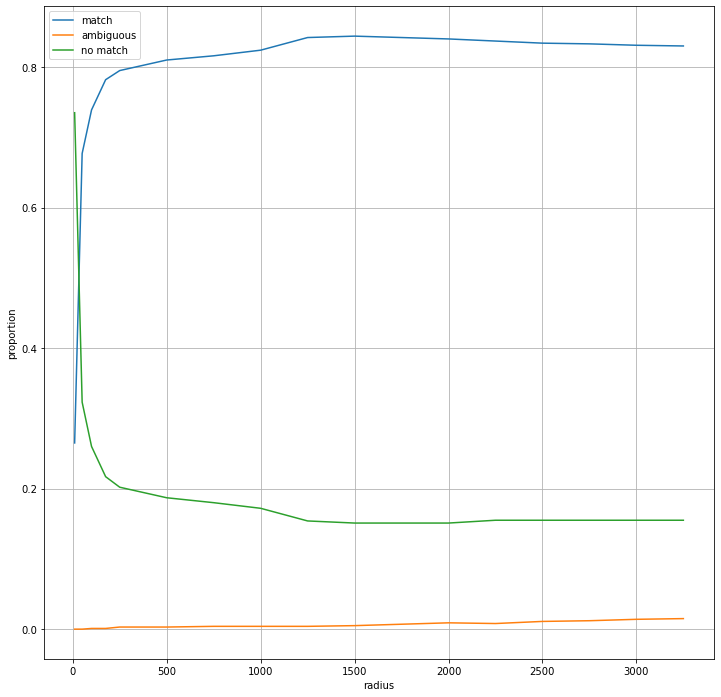

In [184]:
# for r in sorted(matches.keys()):
#     print('####', r, '####')
#     print('match:', np.sum(np.array(matches[r]) == 1) / len(matches[r]))
#     print('ambiguous:', np.sum(np.array(matches[r]) > 1) / len(matches[r]))
#     print('no match:', np.sum(np.array(matches[r]) == 0) / len(matches[r]))
r_list = list(sorted(matches.keys()))
ax = plt.subplot(1,1,1)
ax.plot(r_list, [np.sum(np.array(matches[r]) == 1) / len(matches[r]) for r in r_list], label='match')
ax.plot(r_list, [np.sum(np.array(matches[r]) > 1) / len(matches[r]) for r in r_list], label='ambiguous')
ax.plot(r_list, [np.sum(np.array(matches[r]) == 0) / len(matches[r]) for r in r_list], label='no match')
ax.legend()
plt.xlabel('radius')
plt.ylabel('proportion')
plt.grid()

### perform matching

In [31]:
# add empty rows with indices -1 and -2; these will be retrieved if there is no match address match
# this enables us to use a list of indices to get all information in one step, rather than iterating over in a for loop
addresses.loc[-1] = addresses.loc[1]
for c in addresses.columns:
    addresses.loc[-1, c] = np.nan
    addresses.loc[-1, c]
addresses.loc[-2] = addresses.loc[-1]

#### Non ranged addresses  
Matches with more than 80% success rate for numbered bcs.  
Matches more than half the time for numbered bcs that weren't already on the correct parcel.

In [109]:
%%time
r = 1250
bcs_to_match = bcs_numbered[bcs_numbered.LINZ_MATCH_CODE.isna()]
bc_tree = cKDTree(np.array(list(bcs_to_match.geometry.apply(lambda x: (x.x, x.y)))))
# this creates a list of lists, where the ith list contains the the neighbours of the ith bc
bc_tree_neighbours = bc_tree.query_ball_tree(addresses_tree, r)

def perform_matching(item):
    """check if there is a neighbouring point that matches on number_name
    
    arguments:
    item - (i, neighbours), where neighbours is the result of query_ball_tree
    
    returns:
        - the index of the matching address, if there is a unique match
        - -1 if there is more than one match
        - -2 if there are no matches
    """
    i, neighbours = item
    # subset right to those within r distance
    right_neighbours = addresses.iloc[neighbours]
    # check how many matches there are
    match_indicator = bcs_to_match.iloc[i]['number_name'] == right_neighbours['number_name']
    if np.sum(match_indicator) == 1:
        # extract the index from right_neighbours
        # extracting the index only and later subsetting the full addresses dataframe
        # results in a ~4x speed up over extracting the requisite addresses information within this for loop
        return right_neighbours[match_indicator].index[0]
    elif np.sum(match_indicator) > 1:
        return -1
    else:
        return -2

match_indices = process_map(perform_matching, enumerate(bc_tree_neighbours), max_workers=max_workers, chunksize=100, total=len(bc_tree_neighbours))
print('#### r =', r, '####')
print('match:', np.sum(np.array(match_indices) > -1) / len(match_indices))
print('ambiguous:', np.sum(np.array(match_indices) == -1) / len(match_indices))
print('no match:', np.sum(np.array(match_indices) == -2) / len(match_indices))

  0%|          | 0/58150 [00:00<?, ?it/s]

#### r = 1250 ####
match: 0.5643852106620808
ambiguous: 0.005141874462596733
no match: 0.43047291487532247
CPU times: user 41.8 s, sys: 38.8 s, total: 1min 20s
Wall time: 1min 59s


In [110]:
bcs_to_match['addresses_geometry'] = addresses.loc[match_indices].geometry.reset_index(drop=True).tolist()
bcs_to_match['addresses_full_address'] = addresses.loc[match_indices].full_address.reset_index(drop=True).tolist()
bcs_to_match['euc_distance'] = [np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2) for a, b in zip(bcs_to_match.geometry.apply(lambda x: (x.x, x.y)), bcs_to_match['addresses_geometry'].apply(lambda x: (x.x, x.y) if not pd.isna(x) else (0, 0)))]

/home/ubuntu/miniconda3/envs/house-upzone/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/home/ubuntu/miniconda3/envs/house-upzone/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Text(0, 0.5, 'Distance to Matched Address (metres)')

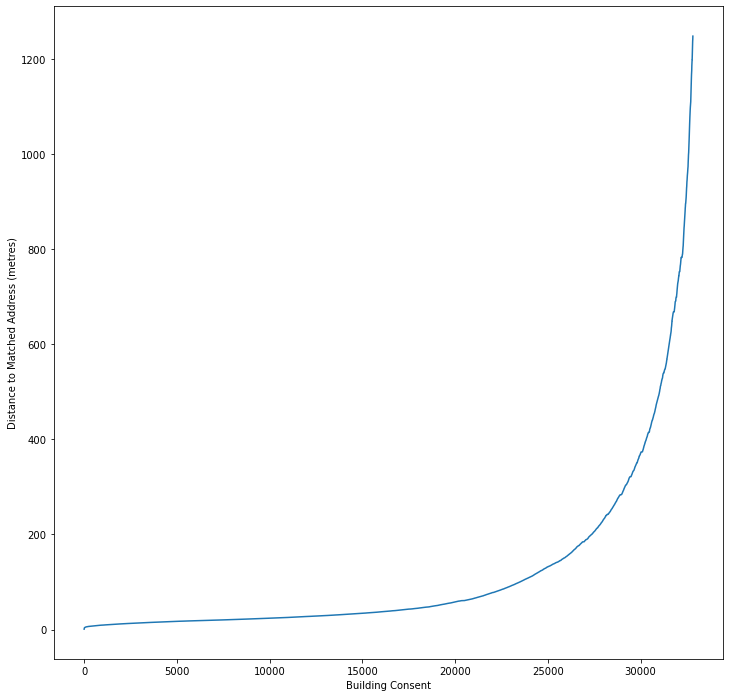

In [112]:
bcs_to_match[~bcs_to_match.addresses_full_address.isna()].sort_values('euc_distance').reset_index(drop=True).euc_distance.plot()
plt.xlabel('Building Consent')
plt.ylabel('Distance to Matched Address (metres)')

In [227]:
bcs_to_match.sample(20).sort_values('euc_distance')[['full_address', 'addresses_full_address', 'euc_distance']].to_csv('address_match_sample.csv')

In [113]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(bcs_to_match.sample(20).sort_values('euc_distance')[['full_address', 'addresses_full_address', 'euc_distance']])

,full_address,addresses_full_address,euc_distance
62594,21 park ave otahuhu,"21 Park Avenue, Otahuhu, Auckland",1.705363e+01
171341,42a vale rd st heliers,"42A Vale Road, St Heliers, Auckland",1.945624e+01
134508,322a great south rd papakura,"322A Great South Road, Opaheke, Papakura",2.201203e+01
185607,30c takanini school rd takanini,"30C Takanini School Road, Takanini",2.852696e+01
48579,8c beach road manly,"8C Beach Road, Manly, Whangaparaoa",3.657548e+01
91273,50 clarence st ponsonby,"50 Clarence Street, Ponsonby, Auckland",6.234833e+01
57463,438 waitoki rd wainui,"438 Waitoki Road, Wainui",7.786977e+01
48632,4 sawyers lane silverdale,"4 Sawyers Lane, Silverdale",1.302613e+02
191130,542 east coast rd campbells bay,"542 East Coast Road, Windsor Park, Auckland",1.336436e+02
175568,166/172 mcleod rd te atatu south,"166/172 McLeod Road, Te Atatu South, Auckland",1.859874e+02


### Ranged addresses

In [10]:
# all number ranges that have a non digit in them
for index, row in tqdm(bcs_ranged.iterrows(), total=len(bcs_ranged)):
    r = row.number_name.split(' ')[0].split('/')[0]
    if not all([s.isdecimal() for s in r.split('-')]):
        print(row.number_name.split(' ')[0])

  0%|          | 0/6267 [00:00<?, ?it/s]

12-26d
12-26d
140-140b
421-455a
12-26d
12-26d
140-140b
121-131buckley
11-15a
11-15a
421-455a
13-13a
421-455a
15-15a
1-1a
33-35a
2-2a
21-21a
67-69a
67-69a
67-69a
39-39a
15-19a
211-218b
9-9a
1-1a
41-41a
27-27a
3-5a
3-5a
35-35c
13-13a
27-27a
27-27a
27-27a
11-11a
508-508a
29-29a
95-97c
180-180a
180-180a


In [142]:
# check the proportion of ranged addresses that have endpoints matching in being either even or odd
# if this proportion is high, then 20-26 should become 20, 22, 24, 26
endpoints_match = []
for index, row in tqdm(bcs_ranged.iterrows(), total=len(bcs_ranged)):
    r = row.number_name.split(' ')[0].split('/')[0]
    if all([s.isdecimal() for s in r.split('-')]):
        endpoints = [s for s in r.split('-')]
        if '/' not in row.number_name:
            endpoints_match.append(int(endpoints[0]) % 2) == (int(endpoints[1]) % 2)
# proportion is around what you would expect by chance
sum(endpoints_match) / len(endpoints_match)

  0%|          | 0/6267 [00:00<?, ?it/s]

0.5130575831305758

In [141]:
def range_expand(r):
    """given a range r, like '20-23', expand the range on one side of the road, e.g. ['20', '21', '22', '23']"""
    if '/' in r:
        r, suffix = r.split('/')
        suffix = '/' + suffix
    else:
        suffix = ''
    r1, r2 = r.split('-')
    if r1.isdecimal() and r2.isdecimal():
        return [str(i) + suffix for i in range(int(r1), int(r2) + 1)]
    else:
        return r + suffix

In [143]:
range_expand('20-28')

['20', '21', '22', '23', '24', '25', '26', '27', '28']

In [144]:
range_expand('1-5/32a')

['1/32a', '2/32a', '3/32a', '4/32a', '5/32a']

In [148]:
# get a list of gdfs, one gdf per ranged bc 
# each gdf expands a row of bcs_ranged into many rows, one for each number in the range
expanded_gdfs = []
for index, row in tqdm(bcs_ranged.iterrows(), total=len(bcs_ranged)):
    number_name = row.number_name.split(' ')
    number = number_name[0]
    name = number_name[1]
    range_expanded = range_expand(number)
    
    range_rows = [row.copy() for _ in range(len(range_expanded))]
    for i, rr in enumerate(range_rows):
        rr.number_name = range_expanded[i] + ' ' + name
    
    expanded_gdfs.append(pd.DataFrame(range_rows))
expanded_gdfs[0]

  0%|          | 0/6267 [00:00<?, ?it/s]

,OBS,CONSENT_DATE,MARCH_YEAR,ADDRESS_1,ADDRESS_2,ADDRESS_3,LB_Name,BUILDING_TYPE_NAME,BUILDING_TYPE_CODE,FLOOR_AREA,VALUE,BUILDINGS,Building_Type_Group,Residential_Type,Business_Group,Business_Category,Type_Class_Year,MBCODE,MBYEAR,AUP_BaseZone,AUP_BaseZone_Group,ZONE,ZONE_ID,ZONE_NAME,ZONE_TYPE,BUSINESS_TYPE,PlanAreaName,SHA_Name_154,X_Coordinate,Y_Coordinate,geometry,number_name,full_address
12,228134,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",7-19 TONAR STREET,Northcote,Auckland,Kaipatiki,Apartments,1121,2905.0,NaN,29,Residential,Attached,NaN,NaN,2014,364300.0,2013.0,Residential - Terrace Housing and Apartment Bu...,Residential,8.0,NSC_5611,Residential 6A1,Residential,NaN,Northcote Strategic Area,Northcote Strategic Area,174.74724,-36.795608,POINT (1755884.5965335 5926377.252129991),7 tonar,7-19 tonar street northcote auckland
12,228134,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",7-19 TONAR STREET,Northcote,Auckland,Kaipatiki,Apartments,1121,2905.0,NaN,29,Residential,Attached,NaN,NaN,2014,364300.0,2013.0,Residential - Terrace Housing and Apartment Bu...,Residential,8.0,NSC_5611,Residential 6A1,Residential,NaN,Northcote Strategic Area,Northcote Strategic Area,174.74724,-36.795608,POINT (1755884.5965335 5926377.252129991),8 tonar,7-19 tonar street northcote auckland
12,228134,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",7-19 TONAR STREET,Northcote,Auckland,Kaipatiki,Apartments,1121,2905.0,NaN,29,Residential,Attached,NaN,NaN,2014,364300.0,2013.0,Residential - Terrace Housing and Apartment Bu...,Residential,8.0,NSC_5611,Residential 6A1,Residential,NaN,Northcote Strategic Area,Northcote Strategic Area,174.74724,-36.795608,POINT (1755884.5965335 5926377.252129991),9 tonar,7-19 tonar street northcote auckland
12,228134,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",7-19 TONAR STREET,Northcote,Auckland,Kaipatiki,Apartments,1121,2905.0,NaN,29,Residential,Attached,NaN,NaN,2014,364300.0,2013.0,Residential - Terrace Housing and Apartment Bu...,Residential,8.0,NSC_5611,Residential 6A1,Residential,NaN,Northcote Strategic Area,Northcote Strategic Area,174.74724,-36.795608,POINT (1755884.5965335 5926377.252129991),10 tonar,7-19 tonar street northcote auckland
12,228134,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",7-19 TONAR STREET,Northcote,Auckland,Kaipatiki,Apartments,1121,2905.0,NaN,29,Residential,Attached,NaN,NaN,2014,364300.0,2013.0,Residential - Terrace Housing and Apartment Bu...,Residential,8.0,NSC_5611,Residential 6A1,Residential,NaN,Northcote Strategic Area,Northcote Strategic Area,174.74724,-36.795608,POINT (1755884.5965335 5926377.252129991),11 tonar,7-19 tonar street northcote auckland
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,228134,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",7-19 TONAR STREET,Northcote,Auckland,Kaipatiki,Apartments,1121,2905.0,NaN,29,Residential,Attached,NaN,NaN,2014,364300.0,2013.0,Residential - Terrace Housing and Apartment Bu...,Residential,8.0,NSC_5611,Residential 6A1,Residential,NaN,Northcote Strategic Area,Northcote Strategic Area,174.74724,-36.795608,POINT (1755884.5965335 5926377.252129991),15 tonar,7-19 tonar street northcote auckland
12,228134,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",7-19 TONAR STREET,Northcote,Auckland,Kaipatiki,Apartments,1121,2905.0,NaN,29,Residential,Attached,NaN,NaN,2014,364300.0,2013.0,Residential - Terrace Housing and Apartment Bu...,Residential,8.0,NSC_5611,Residential 6A1,Residential,NaN,Northcote Strategic Area,Northcote Strategic Area,174.74724,-36.795608,POINT (1755884.5965335 5926377.252129991),16 tonar,7-19 tonar street northcote auckland
12,228134,"Feb 01, 2021 12:00:00 AM","Mar 01, 2020 12:00:00 AM",7-19 TONAR STREET,Northcote,Auckland,Kaipatiki,Apartments,1121,2905.0,NaN,29,Residential,Attached,NaN,NaN,2014,364300.0,2013.0,Residential - Terrace Housing and Apartment Bu...,Residential,8.0,NSC_5611,Resid